In [2]:
import tweepy
import csv
import pandas as pd
import tqdm

In [3]:
bearer_token ="your_token"
auth = tweepy.OAuth2BearerHandler(bearer_token)
api = tweepy.API(auth, wait_on_rate_limit=True)

In [3]:
# uk parlament list
list_members = api.get_list_members(list_id=217199644, count=1000)
list_id = []
for user in list_members:
    list_id.append(user._json['id'])
len(list_members)

535

In [4]:
matrix_dict = {uid: [] for uid in list_id}

In [ ]:
for user_id in tqdm.tqdm(list_id):
    friends = api.get_friend_ids(user_id=user_id, max_results = 1000)
    for friend_id in friends:
        if friend_id in list_id:
            matrix_dict[friend_id] += [user_id]

  3%|▎         | 15/535 [00:19<13:32,  1.56s/it]Unexpected parameter: max_results
Rate limit reached. Sleeping for: 880
  6%|▌         | 30/535 [15:17<21:55,  2.61s/it]Unexpected parameter: max_results
Rate limit reached. Sleeping for: 888
  8%|▊         | 45/535 [30:15<19:02,  2.33s/it]Unexpected parameter: max_results
Rate limit reached. Sleeping for: 892
 11%|█         | 60/535 [45:16<18:51,  2.38s/it]Unexpected parameter: max_results
Rate limit reached. Sleeping for: 892
 14%|█▍        | 75/535 [1:00:17<19:03,  2.48s/it]Unexpected parameter: max_results
Rate limit reached. Sleeping for: 892


In [28]:
import json

# Serialize data into file:
json.dump(matrix_dict, open("data/graph_dict.json", 'w'))

### Vis

In [20]:
import seaborn as sns
import networkx as nx
import json
import matplotlib.pyplot as plt
import community.community_louvain as louvain
import numpy as np
import tqdm

colors = sns.color_palette("tab10")
colors_dark = sns.color_palette("dark")

In [21]:
# Read data from file:
matrix_dict = json.load(open("data/graph_dict.json"))

In [22]:
matrix_dict_fix = {}
for k, v in matrix_dict.items():
    matrix_dict_fix[int(k)] = v
matrix_dict = matrix_dict_fix

In [23]:
G = nx.from_dict_of_lists(matrix_dict)

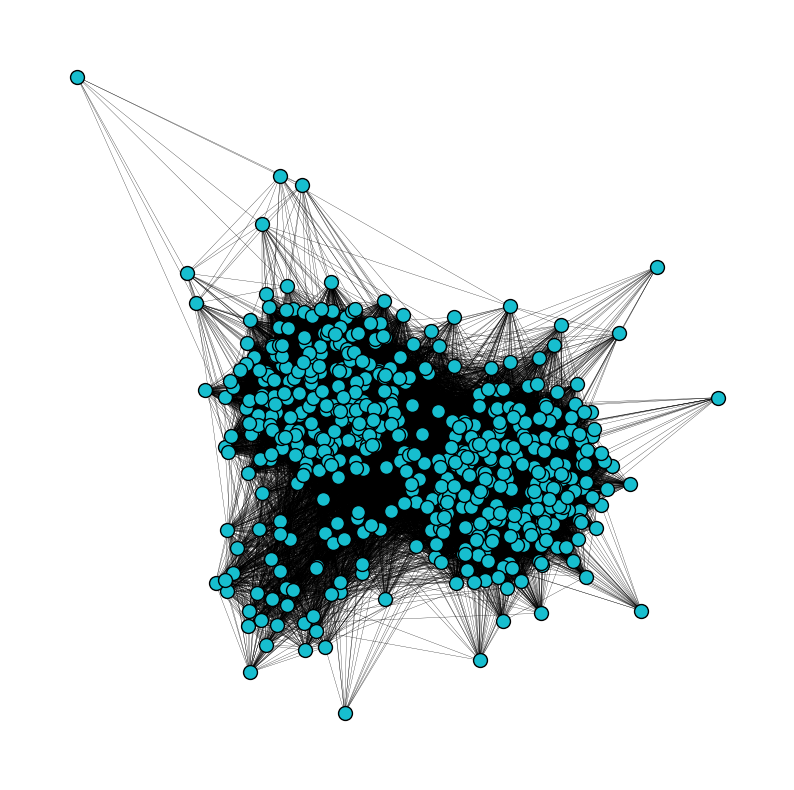

In [11]:
plt.figure(figsize=(10, 10))

np.random.seed(11)
pos_init = nx.spring_layout(G)
nx.draw_networkx(G, pos=pos_init, with_labels=False, node_size=70, width=0.2)
nodes = nx.draw_networkx_nodes(G, pos=pos_init, node_size=100, node_color=colors[-1])

nodes.set_edgecolor('black')
plt.box(False)

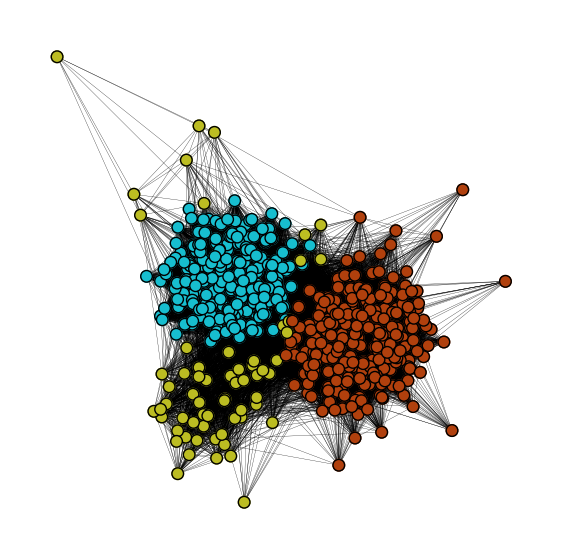

In [48]:
plt.figure(figsize=(7, 7))

np.random.seed(11)
pos = nx.spring_layout(G)

part = louvain.best_partition(G)
values = [part.get(node) for node in G.nodes()]

colors_dict = {0: colors_dark[1], 1: colors[-2], 2: colors[-1]}
node_colors = [colors_dict[part.get(node)] for node in G.nodes()]
nx.draw_networkx(G, pos=pos, node_color=node_colors, with_labels=False, node_size=70, width=0.2)
nodes = nx.draw_networkx_nodes(G, pos=pos, node_color=node_colors, node_size=70)

nodes.set_edgecolor('black')
plt.box(False)

### beliefs

In [50]:
beliefs = json.load(open("data/belifs_avg_dict0104.json"))
G = nx.from_dict_of_lists(matrix_dict)

In [26]:
beliefs_colors = []
for user in tqdm.tqdm(G.nodes()):
    color = 'grey'
    if beliefs[str(user)] > 0.5:
        color = 'red'
    elif beliefs[str(user)] < 0.5:
        color = 'blue'
    beliefs_colors.append(color)

100%|█████████████████████████████████████| 535/535 [00:00<00:00, 715090.07it/s]


In [51]:
beliefs_code = []
for user in tqdm.tqdm(G.nodes()):
    beliefs_code.append(beliefs[str(user)])

100%|█████████████████████████████████████| 535/535 [00:00<00:00, 642414.15it/s]


In [16]:
import numpy as np
nodes_sub = []
beliefs_code = []
beliefs_colors = []
for k, v in beliefs.items():
    if v > 0.9 or v < 0.1:
        nodes_sub.append(int(k))
        beliefs_code.append(v)
        if v > 0.5:
            beliefs_colors.append('red')
        else:
            beliefs_colors.append('blue')
        
G = G.subgraph(nodes_sub)
len(G)

108

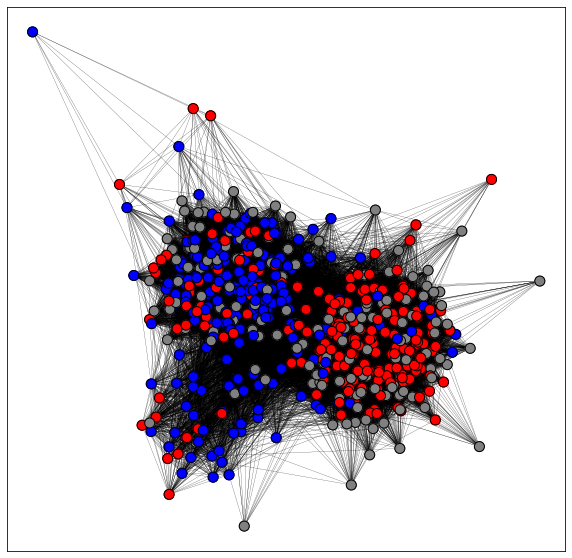

In [277]:
plt.figure(figsize=(10, 10))
nx.draw_networkx(G, pos=pos, node_color=beliefs_colors, with_labels=False, node_size=100, width=0.2)
nodes = nx.draw_networkx_nodes(G, pos=pos, node_color=beliefs_colors, with_labels=False, node_size=100, width=0.5)
nodes.set_edgecolor('black')

In [63]:
import matplotlib

font = {'size': 14}
matplotlib.rc('font', **font)

/var/folders/l6/c459dpf17p59w60nyx09r4x00000gp/T/ipykernel_89556/1026089137.py:17: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, orientation="horizontal")


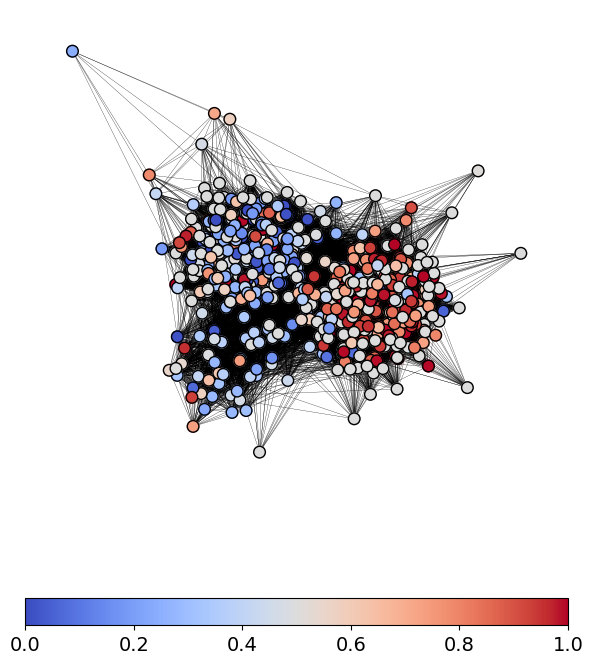

In [64]:
plt.figure(figsize=(7, 9))
cmap = sns.color_palette("coolwarm", as_cmap=True)

nx.draw_networkx(G, pos=pos, node_color=beliefs_code, with_labels=False, node_size=70, cmap=cmap, width=0.2)

nodes = nx.draw_networkx_nodes(G, pos=pos, node_color=beliefs_code, node_size=70, cmap=cmap, vmin=0, vmax=1)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=1))
sm.set_array([])
cbar = plt.colorbar(sm, orientation="horizontal")

plt.box(False)
nodes.set_edgecolor('black')